In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

Using backend: tensorflow.compat.v1

2023-07-29 16:04:27.912274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


2023-07-29 16:04:41.402151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-29 16:04:41.964662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-29 16:04:41.965340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Enable just-in-time compilation with XLA.




In [13]:
n = 3
l = 0
m = 0
Z = 1
r_max = 50

In [14]:
def azimuth_part(phi):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(phi * m * 1j)

In [15]:
def polar_part(theta):
    # 2*pi is already at the z_component
    normalization_constant = ((-1) ** m) * np.sqrt(((2 * l + 1) / 2) * (np.math.factorial(l - m) / np.math.factorial(l + m)))
    legendre_values = []
    for i in theta:
        legendre_polynomials, _ = sp.lpmn(m, l, np.cos(i[0]))
        legendre = legendre_polynomials[m, l]
        legendre_values.append([legendre])
    legendre_values = np.array(legendre_values)
    
    return normalization_constant * legendre_values

In [16]:
def radial_part(r):
    normalization_constant = np.sqrt(
        np.power(2.0 / n, 3.0) * (np.math.factorial(n - l - 1) / (2 * n * np.math.factorial(n + l)))
    )
    
    exponent = np.exp(- (Z * r) / n)
    power = np.power(2 * Z * r / n, l)
    laguerre_polynomial = sp.genlaguerre(n - l - 1, 2 * l + 1)
    laguerre_value = laguerre_polynomial(2 * Z * r / n)
    
    return normalization_constant * exponent * power * laguerre_value

In [17]:
domain = dde.geometry.Interval(0, r_max)

In [18]:
num_train = 64
num_test = 100
data = dde.data.Function(domain, radial_part, num_train, num_test)

In [19]:
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN([1] + [50] * 5 + [1], activation, initializer)

In [20]:
model = dde.Model(data, net)
model.compile('adam', lr=0.001, metrics=['l2 relative error'])

Compiling model...
Building feed-forward neural network...
'build' took 0.085464 s

'compile' took 0.272353 s



2023-07-29 16:07:18.330664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-29 16:07:18.331000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-29 16:07:18.331248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [21]:
loss_history, train_state = model.train(iterations=10000)

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [3.04e-02]    [3.01e-02]    [3.59e+00]    
1000      [4.41e-06]    [5.65e-06]    [4.92e-02]    
2000      [9.82e-07]    [1.63e-06]    [2.65e-02]    
3000      [3.15e-07]    [6.67e-07]    [1.69e-02]    
4000      [2.29e-07]    [4.95e-07]    [1.46e-02]    
5000      [1.88e-07]    [5.91e-07]    [1.59e-02]    
6000      [7.40e-08]    [4.81e-07]    [1.44e-02]    
7000      [3.01e-05]    [3.05e-05]    [1.14e-01]    
8000      [3.47e-08]    [4.38e-07]    [1.37e-02]    
9000      [2.38e-08]    [4.21e-07]    [1.34e-02]    
10000     [1.82e-07]    [8.73e-07]    [1.94e-02]    

Best model at step 9000:
  train loss: 2.38e-08
  test loss: 4.21e-07
  test metric: [1.34e-02]

'train' took 11.171249 s



Saving loss history to /home/piotr/repos/quant-chem-pinns/hydrogen-atom/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/hydrogen-atom/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/hydrogen-atom/test.dat ...


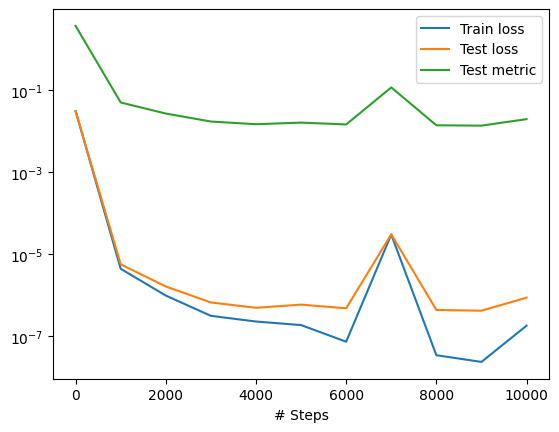

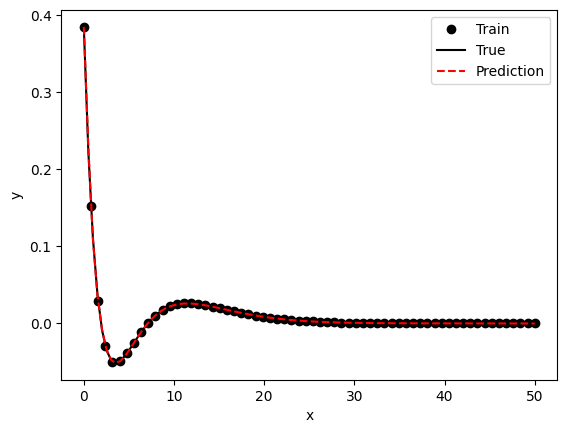

In [22]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [70]:
def plot_radial_distribution(grid_dist=0.1):
    r_values = np.arange(0, r_max, grid_dist)
    
    true_values = np.power(r_values, 2) * np.power(radial_part(r_values), 2)
    predicted_values = np.power(model.predict(np.reshape(np.copy(r_values), (r_values.shape[0], 1))), 2)
    predicted_values = predicted_values.squeeze()
    predicted_values = np.power(r_values, 2) * predicted_values
    
    plt.plot(r_values, true_values, 'b-', label='true')
    plt.plot(r_values, predicted_values, 'r--', label='predicted')
    
    plt.legend()
    

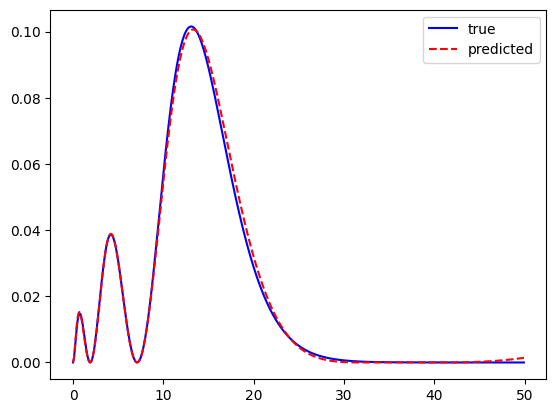

In [71]:
plot_radial_distribution()